In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                   import linear_model, ensemble, preprocessing
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics           import r2_score, mean_squared_error, accuracy_score
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.naive_bayes       import MultinomialNB, GaussianNB

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 6
%matplotlib inline

In [222]:
covid_df = pd.read_csv('data/covid_nsw_data.csv', parse_dates=['notification_date'])
income_df = pd.read_csv('data/income_data.csv', index_col=['Postcode'])
opal_df = pd.read_csv('data/opal_patronage_data.csv', parse_dates=['trip_origin_date'])

In [223]:
# Changing header names for dataframes
covid_headers = ['date', 'postcode', 'source', 'health_district', 'health_district_name', 'local_gov_code', 'local_gov_name']
opal_headers = ['date', 'mode_type', 'region', 'tap_hour', 'tap_on', 'tap_off']

covid_df.columns = covid_headers
opal_df.columns = opal_headers

In [224]:
#take columns that are needed and update dataframes
covid_df = covid_df[['date', 'postcode', 'source', 'health_district_name', 'local_gov_name']]
opal_df = opal_df[['date', 'mode_type', 'region','tap_on', 'tap_off']]

In [225]:
#groupby day
covid_df['health_district_name'].unique()

array(['Sydney', 'Northern Sydney', 'South Eastern Sydney',
       'South Western Sydney', 'Western Sydney', 'Southern NSW', nan,
       'Nepean Blue Mountains', 'Western NSW', 'Central Coast',
       'Mid North Coast', 'Hunter New England', 'Northern NSW',
       'Illawarra Shoalhaven', 'Network with Vic', 'Murrumbidgee',
       'Far West'], dtype=object)

In [226]:
covid_df.local_gov_name

0           Burwood (A)
1        Parramatta (C)
2       Ku-ring-gai (A)
3          Randwick (C)
4         Fairfield (C)
             ...       
3976                NaN
3977                NaN
3978                NaN
3979       Randwick (C)
3980                NaN
Name: local_gov_name, Length: 3981, dtype: object

In [227]:
#Creating column with different name for to make manipulation easier later on.
covid_df['region'] = covid_df['local_gov_name'].str.split('(').str[0]
covid_df

,date,postcode,source,health_district_name,local_gov_name,region
0,2020-01-25,2134.0,Overseas,Sydney,Burwood (A),Burwood
1,2020-01-25,2121.0,Overseas,Northern Sydney,Parramatta (C),Parramatta
2,2020-01-25,2071.0,Overseas,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai
3,2020-01-27,2033.0,Overseas,South Eastern Sydney,Randwick (C),Randwick
4,2020-03-01,2163.0,Overseas,South Western Sydney,Fairfield (C),Fairfield
...,...,...,...,...,...,...
3976,2020-09-12,NaN,Overseas,NaN,NaN,NaN
3977,2020-09-12,NaN,Overseas,NaN,NaN,NaN
3978,2020-09-13,NaN,Overseas,NaN,NaN,NaN
3979,2020-09-13,2035.0,Locally acquired - contact of a confirmed case...,South Eastern Sydney,Randwick (C),Randwick


In [228]:
#Selecting only certain regions.
covid_df=covid_df[covid_df.region.isin(['North Sydney ','Parramatta ','Ryde ', 'Ku-ring-gai ','Strathfield '])]
covid_df.reset_index(inplace=True)

In [229]:
covid_df

,index,date,postcode,source,health_district_name,local_gov_name,region
0,1,2020-01-25,2121.0,Overseas,Northern Sydney,Parramatta (C),Parramatta
1,2,2020-01-25,2071.0,Overseas,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai
2,6,2020-03-02,2073.0,Locally acquired - source not identified,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai
3,13,2020-03-03,2122.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C),Ryde
4,15,2020-03-04,2113.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C),Ryde
...,...,...,...,...,...,...,...
311,3913,2020-09-04,2069.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai
312,3941,2020-09-08,2061.0,Locally acquired - contact of a confirmed case...,Northern Sydney,North Sydney (A),North Sydney
313,3944,2020-09-08,2072.0,Overseas,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai
314,3946,2020-09-09,2115.0,Locally acquired - contact of a confirmed case...,Western Sydney,Parramatta (C),Parramatta


In [230]:
#Total Cases in each picked region.
covid_df['region'].value_counts()

Ku-ring-gai      87
Parramatta       81
Ryde             74
North Sydney     51
Strathfield      23
Name: region, dtype: int64

### Due to regions ChatsWood and Macquarie Park not being present in the original data We have selected the regions closed to them as an assumption inorder to continue with the analysis;

### ChatsWood - Ku-ring-gai  
### Macquarie Park - Ryde  

# ## @@ tom though of commenting this instead of chaning the graph row names as it could stay consistent throughout the file

Text(0.5, 1.0, 'Number of Cases throughout the Year in Each Region')

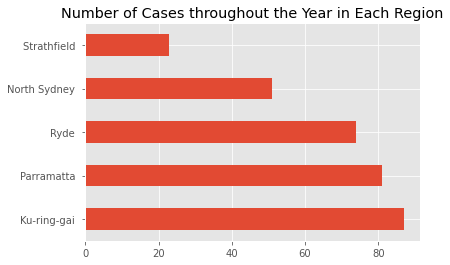

In [231]:
#Bar Plot of region against total no of cases.
covid_df['region'].value_counts()[:20].plot(kind='barh').set_title("Number of Cases throughout the Year in Each Region")

In [232]:
#Created a column which contains the total no. of cases per day in aech region
covid_df['Cases'] = covid_df['date'].map(covid_df['date'].value_counts())

<ipython-input-232-7bc06e75118d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df['Cases'] = covid_df['date'].map(covid_df['date'].value_counts())


In [233]:
covid_df.head(100)

,index,date,postcode,source,health_district_name,local_gov_name,region,Cases
0,1,2020-01-25,2121.0,Overseas,Northern Sydney,Parramatta (C),Parramatta,2
1,2,2020-01-25,2071.0,Overseas,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai,2
2,6,2020-03-02,2073.0,Locally acquired - source not identified,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai,1
3,13,2020-03-03,2122.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C),Ryde,1
4,15,2020-03-04,2113.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C),Ryde,4
...,...,...,...,...,...,...,...,...
95,1009,2020-03-24,2074.0,Overseas,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai,14
96,1010,2020-03-24,2090.0,Locally acquired - contact of a confirmed case...,Northern Sydney,North Sydney (A),North Sydney,14
97,1017,2020-03-24,2112.0,Locally acquired - source not identified,Northern Sydney,Ryde (C),Ryde,14
98,1018,2020-03-24,2069.0,Overseas,Northern Sydney,Ku-ring-gai (A),Ku-ring-gai,14


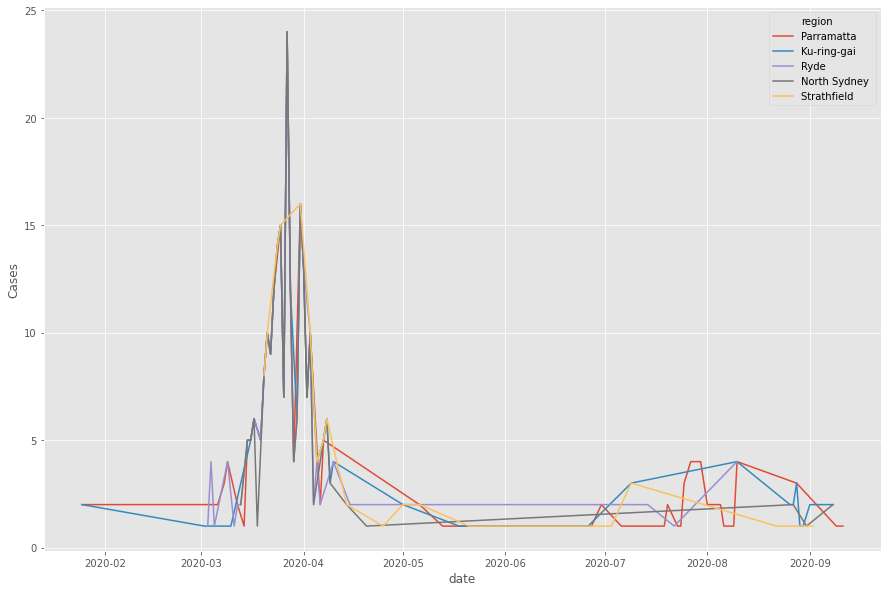

In [234]:
#Line Plot Comparing the number of cases each month, with relation to region
plt.figure(figsize=(15,10))
sns.lineplot(data = covid_df, x = 'date', y = 'Cases', hue = 'region',)
plt.show()

In [235]:
# Creating tables for each region, for individual exploration
Ryde_Cases=(covid_df[covid_df["region"]=="Ryde "][["date","Cases", "region"]])
Parramatta_Cases=(covid_df[covid_df["region"]=="Parramatta "][["date","Cases", "region"]])
NorthSydney_Cases=(covid_df[covid_df["region"]=="North Sydney "][["date","Cases", "region"]])
Kuring_gai_Cases=(covid_df[covid_df["region"]=="Ku-ring-gai "][["date","Cases", "region"]])
Strathfield_Cases=(covid_df[covid_df["region"]=="Strathfield "][["date","Cases", "region"]])

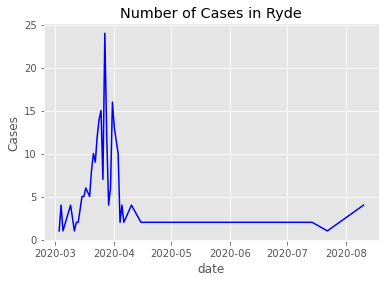

In [236]:
# Line graphs comparing each region's cases monthly.
sns.lineplot(data = Ryde_Cases, x = 'date', y = 'Cases',color='blue').set_title("Number of Cases in Ryde")
plt.show()

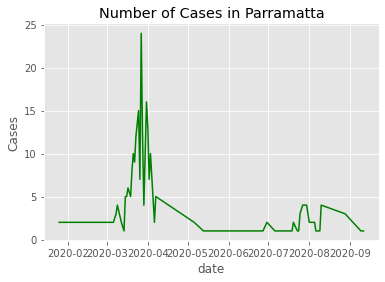

In [237]:
sns.lineplot(data = Parramatta_Cases, x = 'date', y = 'Cases', color='green').set_title("Number of Cases in Parramatta")
plt.show()

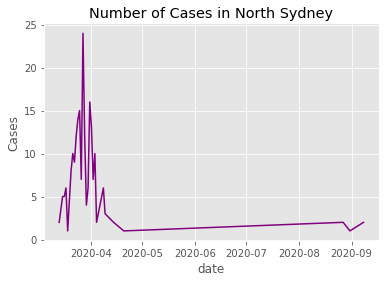

In [238]:
sns.lineplot(data = NorthSydney_Cases, x = 'date', y = 'Cases',  color='purple').set_title("Number of Cases in North Sydney")
plt.show()

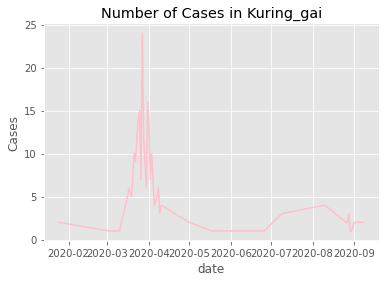

In [239]:
sns.lineplot(data = Kuring_gai_Cases, x = 'date', y = 'Cases', color='pink').set_title("Number of Cases in Kuring_gai")
plt.show()

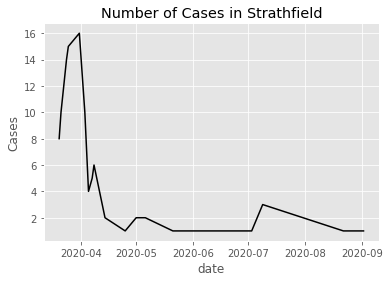

In [240]:
sns.lineplot(data = Strathfield_Cases, x = 'date', y = 'Cases',  color='black').set_title("Number of Cases in Strathfield")
plt.show()

In [241]:
sefia = pd.read_csv('seifa_overview_data.csv')

In [242]:
sefia.head()

,2016 Postal Area (POA) Code,Index of Relative Socio-economic Disadvantage,Index of Relative Socio-economic Disadvantage.1,Index of Relative Socio-economic Advantage and Disadvantage,Index of Relative Socio-economic Advantage and Disadvantage.1,Index of Economic Resources,Index of Economic Resources.1,Index of Education and Occupation,Index of Education and Occupation.1,Usual Resident Population,Data should be used with caution - area not well represented by SA1s,POA crosses state or territory boundaries
0,Unnamed: 0_level_1,Score,Decile,Score,Decile,Score,Decile,Score,Decile,Unnamed: 9_level_1,Unnamed: 10_level_1,Unnamed: 11_level_1
1,800,1066,9,1096,10,946,2,1089,9,6464,NaN,NaN
2,810,1037,8,1052,9,1014,6,1045,8,33302,NaN,NaN
3,812,1013,6,1020,7,1013,6,997,6,18873,NaN,NaN
4,815,1075,9,1096,10,1075,9,1096,9,292,Y,NaN


In [243]:
sefia_df = sefia[['2016 Postal Area (POA) Code', 'Index of Economic Resources.1','Index of Education and Occupation.1']]


In [244]:
sefia_df=sefia_df.rename(columns={"Index of Economic Resources.1": "Economic_resources", "Index of Education and Occupation.1": "Education_and_occupation"})

In [193]:
sefia_df=sefia_df.drop([0])

In [194]:
sefia_df.Economic_resources = pd.to_numeric(sefia_df.Economic_resources, errors="coerce")
sefia_df.Education_and_occupation = pd.to_numeric(sefia_df.Education_and_occupation, errors="coerce")

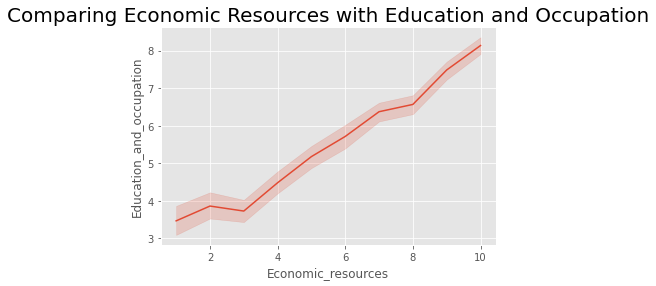

In [195]:
plt.title("Comparing Economic Resources with Education and Occupation", fontsize=20)
sns.lineplot(x='Economic_resources', y='Education_and_occupation',data=sefia_df) 
plt.show()

### This shows a positive linear relationship between the decile scores of Economic  resources with Education and occupation

In [196]:
sefia_headers = ['PostalCode', 'Economic_resources', 'Education_and_occupation']
sefia_df.columns = sefia_headers

In [197]:
sefia_df1 = sefia_df[sefia_df.PostalCode.isin(['2050', '2060', '2067', '2135','2113' , '2000'])]
sefia_df1

,PostalCode,Economic_resources,Education_and_occupation
36,2000,1.0,10
77,2050,1.0,10
79,2060,4.0,10
86,2067,3.0,10
129,2113,7.0,10
148,2135,4.0,9


In [198]:
idx=0
new_col = ['Sydney CBD', 'Paramatta', 'North sydney', 'Chatswood', 'Macquire park', 'Strathfield']
sefia_df1.insert(loc=idx, column='Region', value=new_col)


In [199]:
sefia_df1

,Region,PostalCode,Economic_resources,Education_and_occupation
36,Sydney CBD,2000,1.0,10
77,Paramatta,2050,1.0,10
79,North sydney,2060,4.0,10
86,Chatswood,2067,3.0,10
129,Macquire park,2113,7.0,10
148,Strathfield,2135,4.0,9


In [200]:
sefia_df1.Economic_resources = pd.to_numeric(sefia_df1.Economic_resources, errors="coerce")
sefia_df1.Education_and_occupation = pd.to_numeric(sefia_df1.Education_and_occupation, errors="coerce")

C:\Users\Nehan\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


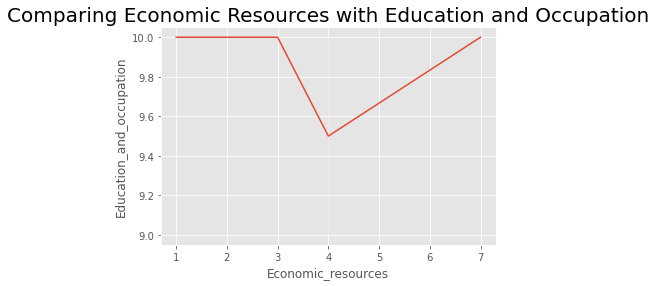

In [201]:
plt.title("Comparing Economic Resources with Education and Occupation", fontsize=20)
sns.lineplot(x='Economic_resources', y='Education_and_occupation',data=sefia_df1) 
plt.show()

### However in the case of out specified stations the relation ship is completely oppositve, this may be due to the selected areas being highlypopulated city areas.

# Comparing Economic Resources to Transport Usage

In [245]:
opal_df["tap_on"].replace({"<50": "50"}, inplace=True)
opal_df["tap_on"] = opal_df["tap_on"].astype(int)
opal_df["tap_off"].replace({"<50": "50"}, inplace=True)
opal_df["tap_off"] = opal_df["tap_off"].astype(int)
opal_df.head()

,date,mode_type,region,tap_on,tap_off
0,2020-01-01,Bus,Chatswood,50,50
1,2020-01-01,Bus,Macquarie Park,50,50
2,2020-01-01,Bus,Newcastle and surrounds,50,50
3,2020-01-01,Bus,North Sydney,700,100
4,2020-01-01,Bus,Other,4500,3200


In [246]:
opal_df = opal_df[opal_df.region.isin(['Chatswood', 'Macquarie Park', 'North Sydney',  'Parramatta', 'Strathfield','Sydney CBD'])]
opal_df.reset_index(inplace=True)


In [247]:
opal_dftal = opal_df.groupby(['date','region']).sum()


In [248]:
opal_dftal['combined_taps'] = opal_dftal.apply(lambda row: row.tap_on + row.tap_off, axis=1)

In [249]:
opal_dftal['Percentage_Taps'] = opal_dftal.apply(lambda row: (row.tap_on / row.combined_taps)*100, axis=1)


In [250]:
opal_dftal.round(decimals=4)
opal_dftal

index  tap_on  tap_off  combined_taps  \
date       region                                                    
2020-01-01 Chatswood         10729   14600    17250          31850   
           Macquarie Park    10777    7900     9850          17750   
           North Sydney      10871   41500    15150          56650   
           Parramatta        10967   20600    26300          46900   
           Strathfield       10957   15300    19650          34950   
...                            ...     ...      ...            ...   
2020-08-31 Macquarie Park  5037745   14400    14200          28600   
           North Sydney    5261784   18250    17750          36000   
           Parramatta      5261878   35800    35100          70900   
           Strathfield     5373904   17700    17050          34750   
           Sydney CBD      5373952  162350   162650         325000   

                           Percentage_Taps  
date       region                           
2020-01-01 Chatswood             45.839874  
           Macquarie Park        44.507042  
           North Sydney          73.256840  
           Parramatta            43.923241  
           Strathfield           43.776824  
...                                    ...  
2020-08-31 Macquarie Park        50.349650  
           North Sydney          50.694444  
           Parramatta            50.493653  
           Strathfield           50.935252  
           Sydney CBD            49.953846  

[1464 rows x 5 columns]

## Comparing The Percentage of Tap Ons betweem stations with similar Economic Resources

In [251]:
opal_dftal.reset_index(inplace=True)
SydneyCBD_vsPamatta_CasesOP1=opal_dftal[opal_dftal.region.isin([ 'Parramatta','Sydney CBD'])]


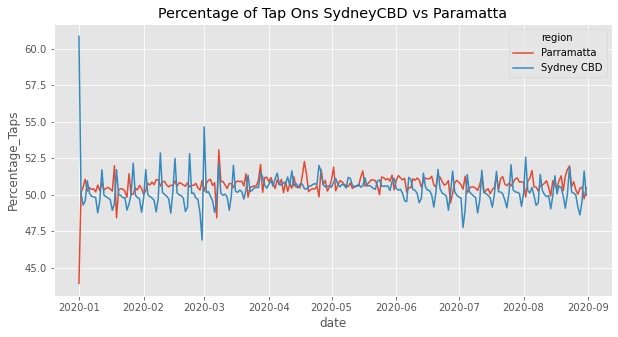

In [252]:
plt.figure(figsize=(10,5))
sns.lineplot(data = SydneyCBD_vsPamatta_CasesOP1, x = 'date', y = 'Percentage_Taps', hue="region").set_title("Percentage of Tap Ons SydneyCBD vs Paramatta")
plt.show()

### Both SydneyCBD and Paramatta had a decile score of 1.0, and the percentage of their taps through out the year remained very constant, especially from the 4th to 6th month when covid was at peak. Within the other months Sydney CBD had a slightly higher percentage, however no vast differance is noticable.

In [253]:
opal_dftal.reset_index(inplace=True)
NorthSydney_vsStrathfield_CasesOP1=opal_dftal[opal_dftal.region.isin([ 'North Sydney','Strathfield'])]
NorthSydney_vsStrathfield_CasesOP1

,level_0,date,region,index,tap_on,tap_off,combined_taps,Percentage_Taps
2,2,2020-01-01,North Sydney,10871,41500,15150,56650,73.256840
4,4,2020-01-01,Strathfield,10957,15300,19650,34950,43.776824
8,8,2020-01-02,North Sydney,31020,27600,28200,55800,49.462366
10,10,2020-01-02,Strathfield,33307,23550,22550,46100,51.084599
14,14,2020-01-03,North Sydney,53041,28150,28300,56450,49.867139
...,...,...,...,...,...,...,...,...
1450,1450,2020-08-29,Strathfield,5329661,14500,13850,28350,51.146384
1454,1454,2020-08-30,North Sydney,5128566,7400,7750,15150,48.844884
1456,1456,2020-08-30,Strathfield,5240421,11100,11000,22100,50.226244
1460,1460,2020-08-31,North Sydney,5261784,18250,17750,36000,50.694444


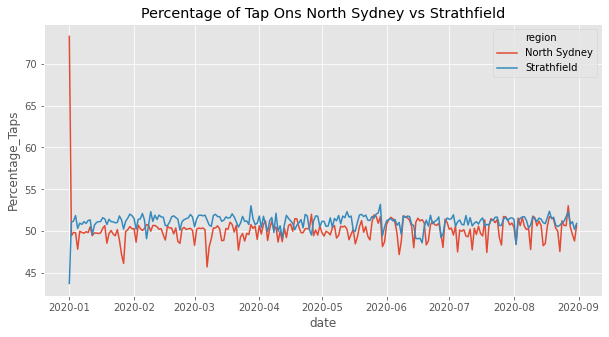

In [254]:
plt.figure(figsize=(10,5))
sns.lineplot(data = NorthSydney_vsStrathfield_CasesOP1, x = 'date', y = 'Percentage_Taps', hue="region").set_title("Percentage of Tap Ons North Sydney vs Strathfield")
plt.show()

### In this case too both regions had the same economic score and  have a very close percentage through out the year witha very few outlier, this would help identify the fact that there is indeed a relationship between Economic Resources and Public Tranport Use. 

In [255]:

MacquirePark_vs_ChatsWood=opal_dftal[opal_dftal.region.isin(['Chatswood','Macquarie Park'])]
MacquirePark_vs_ChatsWood

,level_0,date,region,index,tap_on,tap_off,combined_taps,Percentage_Taps
0,0,2020-01-01,Chatswood,10729,14600,17250,31850,45.839874
1,1,2020-01-01,Macquarie Park,10777,7900,9850,17750,44.507042
6,6,2020-01-02,Chatswood,31596,29300,29700,59000,49.661017
7,7,2020-01-02,Macquarie Park,31642,19150,18750,37900,50.527704
12,12,2020-01-03,Chatswood,52908,29400,29850,59250,49.620253
...,...,...,...,...,...,...,...,...
1447,1447,2020-08-29,Macquarie Park,5107311,9000,8600,17600,51.136364
1452,1452,2020-08-30,Chatswood,5128432,12850,12650,25500,50.392157
1453,1453,2020-08-30,Macquarie Park,5239993,7150,7100,14250,50.175439
1458,1458,2020-08-31,Chatswood,5149668,18300,18400,36700,49.863760


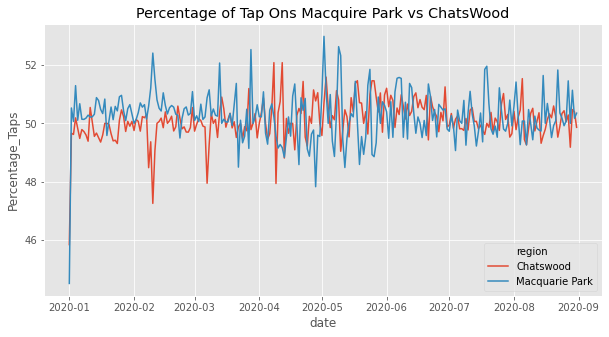

In [256]:
plt.figure(figsize=(10,5))
sns.lineplot(data = MacquirePark_vs_ChatsWood, x = 'date', y = 'Percentage_Taps', hue="region").set_title("Percentage of Tap Ons Macquire Park vs ChatsWood")
plt.show()

### Macquire Park had the highest rescource and seems to have the greatest spread and highest percentage of taps , whilst not big it is a noticable relationship

### Overall it is identifyable that there is a relationship between Economic Resources and Public Tranport Use.